In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.compat.v2.feature_column as fc
import tensorflow as tf

from IPython.display import clear_output

In [26]:
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') # training data
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv') # testing data
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [27]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [28]:
plt.style.use("ggplot")

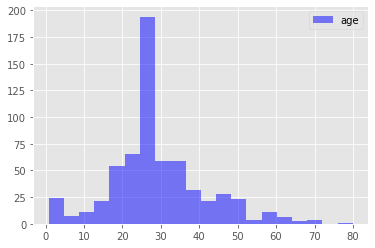

In [29]:
dftrain["age"].hist(bins=20,color="b",legend = True,alpha = 0.50) #Distribution of the age
plt.show() 

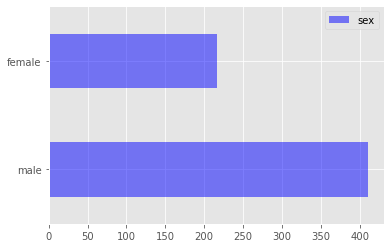

In [30]:
dftrain["sex"].value_counts().plot(kind='barh',alpha=0.5,color="b",legend=True)
plt.show()

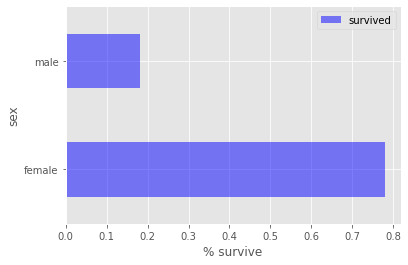

In [31]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh',
                                                                          color="b",
                                                                          legend=True,
                                                                          alpha=0.5).set_xlabel('% survive')
plt.show()

-Most passengers are in their 20's or 30's
-Most passengers are male
-Most passengers are in "Third" class
-Females have a much higher chance of survival

In [32]:
#dividing categorical data from numericas data
def cat_vs_num(df):
    cat_cols = list()
    num_cols = list()
    for col in df.columns:
        if df[col].dtype == "float64":
            num_cols.append(col)
        else:
            cat_cols.append(col)
    return num_cols,cat_cols

num_cols_train,cat_cols_train = cat_vs_num(dftrain)
print(num_cols_train,cat_cols_train)

['age', 'fare'] ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 'embark_town', 'alone']


In [33]:
feature_columns = list()
for feature_name in cat_cols_train:
    uni_values = dftrain[feature_name].unique() #unique values for every feature in the data set
    feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name,uni_values))

for feature_name in num_cols_train:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float64))
print(feature_columns)

#in the tutorial I am following they did not clean the data, or gave a proper treat to missing values, is recomedable to do it.
#for now I will continue as the tutorial goes.

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, def

###The Training Process


So, we are almost done preparing our dataset and I feel as though it's a good time to explain how our model is trained. Specifically, how input data is fed to our model.

For this specific model data is going to be streamed into it in small batches of 32. This means we will not feed the entire dataset to our model at once, but simply small batches of entries. We will feed these batches to our model multiple times according to the number of epochs(epocas).

An epoch is simply one stream of our entire dataset. The number of epochs we define is the amount of times our model will see the entire dataset. We use multiple epochs in hope that after seeing the same data multiple times the model will better determine how to estimate it.

Ex. if we have 10 ephocs, our model will see the same dataset 10 times.

Since we need to feed our data in batches and multiple times, we need to create something called an input function. The input function simply defines how our dataset will be converted into batches at each epoch.

This is done this way bc thats how it is gonna be with large amount of data. I did it just to practice bc for an small data set like this is not necesarily.

###Input Function


The TensorFlow model we are going to use requires that the data we pass it comes in as a ```tf.data.Dataset``` object. This means we must create a *input function* that can convert our current pandas dataframe into that object. 

Below you'll see a seemingly complicated input function, this is straight from the TensorFlow documentation (https://www.tensorflow.org/tutorials/estimator/linear). I've commented as much as I can to make it understandble, but you may want to refer to the documentation for a detailed explination of each method.

In [34]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():  # inner function, this will be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data and its label
    if shuffle:
      ds = ds.shuffle(1000)  # randomize order of data
    ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches of 32 and repeat process for number of epochs
    return ds  # return a batch of the dataset
  return input_function  # return a function object for use

train_input_fn = make_input_fn(dftrain, y_train)  # here we will call the input_function that was returned to us to get a dataset object we can feed to the model
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)


In [35]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
clear_output()

In [36]:
linear_est.train(train_input_fn)  # train
result = linear_est.evaluate(eval_input_fn)  # get model metrics/stats by testing on tetsing data
clear_output() #clear console output
print(result['accuracy'])  # the result variable is simply a dict of stats about our model


0.7689394


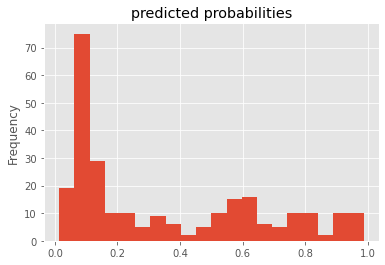

In [38]:
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')
clear_output()